# PatchBoxEmbeddingsVAE Embeddings Analysis

This notebook provides tools for analyzing box embeddings from the PatchBoxEmbeddingsVAE model:

1. **Custom Data Generation**: Generate specific datapoints with controlled parameters
2. **Embedding Extraction**: Extract patch and full-image box embeddings  
3. **Visualization**: Multiple styles to visualize box embeddings across dimensions

Box embeddings represent patches and images as hyper-rectangles with (min, max) bounds in each dimension.


In [1]:
import os
import sys
sys.path.append("/home/ubuntu/workspace/code/compositional-representation-learning")

import yaml
import pickle

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

from pl_modules import PatchBoxEmbeddingsVAE
from datasets import get_dataset

/home/ubuntu/miniconda3/envs/vh-crl/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/ubuntu/miniconda3/envs/vh-crl/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened b

In [2]:
config_filepath = "/home/ubuntu/workspace/code/compositional-representation-learning/configs/PatchBoxEmbeddingsVAE/PatchBoxEmbeddingsVAE_exp_10.yaml"
checkpoint_filepath = "/home/ubuntu/workspace/experiment_root_dir/PatchBoxEmbeddingsVAE/PatchBoxEmbeddingsVAE_exp_10/PatchBoxEmbeddingsVAE_exp_10___2025-11-11__10-43-50/checkpoints/model-epoch=099.ckpt"

with open(config_filepath, "r") as file_handle:
    config = yaml.safe_load(file_handle)

model = PatchBoxEmbeddingsVAE.load_from_checkpoint(checkpoint_filepath, config=config)
model.eval()

PatchBoxEmbeddingsVAE(
  (vae): VanillaVAE(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (2): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (3): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [3]:
dataset = get_dataset(config)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

## Custom Data Generation and Embedding Extraction


In [4]:
import cv2
import numpy as np

def generate_custom_datapoints(param_dicts, config):
    """
    Generate custom datapoints based on provided parameter dictionaries.
    
    Args:
        param_dicts: List of dicts with keys: 'shape' ('circle' or 'square'), 'color' ('red' or 'blue'), 
                     'size' (radius for circle or side_length for square), 'position' (x, y)
        config: Dataset configuration dict
    
    Returns:
        List of dicts with keys: 'images', 'object_masks', 'metadata'
    """
    image_size = config["data"]["train"]["config"]["image_size"]
    color_map = {"red": (255, 0, 0), "blue": (0, 0, 255)}
    
    datapoints = []
    
    for params in param_dicts:
        # Create blank image and mask
        image = np.zeros([image_size[0], image_size[1], 3], dtype=np.uint8)
        mask = np.zeros(image_size, dtype=np.uint8)
        
        shape = params['shape']
        color = color_map[params['color']]
        
        if shape == "circle":
            radius = params['size']
            center = params['position']
            cv2.circle(image, center, radius, color, -1)
            cv2.circle(mask, center, radius, 255, -1)
        elif shape == "square":
            side_length = params['size']
            top_left = params['position']
            cv2.rectangle(
                image,
                top_left,
                (top_left[0] + side_length, top_left[1] + side_length),
                color,
                -1,
            )
            cv2.rectangle(
                mask,
                top_left,
                (top_left[0] + side_length, top_left[1] + side_length),
                255,
                -1,
            )
        
        # Convert to tensors
        image_tensor = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        mask_tensor = torch.from_numpy(mask).float() / 255.0
        
        metadata = {
            "shape": shape,
            "color": params['color'],
            "size": params['size'],
            "position": params['position']
        }
        
        datapoints.append({
            "images": image_tensor,
            "object_masks": mask_tensor,
            "metadata": metadata
        })
    
    return datapoints


In [5]:
def extract_embeddings(model, datapoints):
    """
    Extract box embeddings from the model for given datapoints.
    
    Args:
        model: PatchBoxEmbeddingsVAE model
        datapoints: List of dicts with 'images' and 'object_masks'
    
    Returns:
        List of dicts with:
            - 'patch_boxes': (num_patches, 2, embed_dim) - [min, max] for each patch
            - 'image_box': (2, embed_dim) - [min, max] for full image
            - 'metadata': original metadata
    """
    model.eval()
    results = []
    
    with torch.no_grad():
        for datapoint in datapoints:
            # Prepare batch
            batch = {
                "images": datapoint["images"].unsqueeze(0),  # (1, C, H, W)
                "object_masks": datapoint["object_masks"].unsqueeze(0)  # (1, H, W)
            }
            
            # Forward pass
            outputs = model(batch)
            
            # Extract embeddings
            mu_min = outputs["mu_min"][0]  # (num_patches + 1, embed_dim)
            mu_max = outputs["mu_max"][0]  # (num_patches + 1, embed_dim)
            
            # Separate patches and full image
            patch_boxes = torch.stack([mu_min[:-1], mu_max[:-1]], dim=1)  # (num_patches, 2, embed_dim)
            image_box = torch.stack([mu_min[-1], mu_max[-1]], dim=0)  # (2, embed_dim)
            
            results.append({
                "patch_boxes": patch_boxes.cpu(),
                "image_box": image_box.cpu(),
                "metadata": datapoint.get("metadata", {})
            })
    
    return results


## Box Embedding Visualization


In [16]:
def visualize_box_embeddings(embedding_results, sample_idx=0, figsize=(12, 10)):
    """
    Visualize box embeddings as stacked horizontal bar charts showing intervals.
    
    Args:
        embedding_results: List of dicts from extract_embeddings()
        sample_idx: Index of sample to visualize
        figsize: Figure size tuple
    """
    result = embedding_results[sample_idx]
    patch_boxes = result["patch_boxes"]  # (num_patches, 2, embed_dim)
    image_box = result["image_box"]  # (2, embed_dim)
    metadata = result["metadata"]
    
    num_patches = patch_boxes.shape[0]
    embed_dim = patch_boxes.shape[2]
    
    # Create figure with subplots for each dimension
    num_dims_to_show = min(embed_dim, 16)  # Show up to 16 dimensions
    fig, axes = plt.subplots(num_dims_to_show, 1, figsize=figsize, 
                             constrained_layout=True)
    
    if num_dims_to_show == 1:
        axes = [axes]
    
    # Color palette
    patch_colors = plt.cm.tab20(np.linspace(0, 1, num_patches))
    image_color = 'black'
    
    for dim_idx in range(num_dims_to_show):
        ax = axes[dim_idx]
        
        # Get min and max for this dimension
        patch_mins = patch_boxes[:, 0, dim_idx].numpy()  # (num_patches,)
        patch_maxs = patch_boxes[:, 1, dim_idx].numpy()  # (num_patches,)
        image_min = image_box[0, dim_idx].item()
        image_max = image_box[1, dim_idx].item()
        
        # Calculate intervals
        patch_intervals = patch_maxs - patch_mins
        image_interval = image_max - image_min
        
        # Create horizontal bars
        y_positions = np.arange(num_patches + 1)
        
        # Plot image box (full image embedding)
        ax.barh(0, image_interval, left=image_min, height=0.8, 
                color=image_color, alpha=0.3, edgecolor='black', linewidth=2,
                label='Full Image')
        
        # Plot patch boxes
        for i in range(num_patches):
            label = f'Patch {i+1}' if dim_idx == 0 else None
            ax.barh(i + 1, patch_intervals[i], left=patch_mins[i], height=0.8,
                   color=patch_colors[i], alpha=0.7, edgecolor='black', linewidth=1,
                   label=label)
        
        # Formatting
        ax.set_yticks(y_positions)
        ax.set_yticklabels(['Full Image'] + [f'P{i+1}' for i in range(num_patches)])
        ax.set_xlabel('Embedding Value', fontsize=10)
        ax.set_ylabel('', fontsize=10)
        ax.set_title(f'Dimension {dim_idx + 1}', fontsize=11, fontweight='bold')
        ax.grid(axis='x', alpha=0.3, linestyle='--')
        ax.axvline(x=0, color='red', linestyle='--', linewidth=0.5, alpha=0.5)
        
        # Only show legend for first subplot
        if dim_idx == 0:
            ax.legend(loc='upper right', fontsize=8, ncol=2)
    
    # Add overall title with metadata
    title = f"Box Embeddings: {metadata.get('shape', 'N/A')} - {metadata.get('color', 'N/A')}"
    fig.suptitle(title, fontsize=14, fontweight='bold', y=0.995)
    
    plt.show()
    
    return fig


In [17]:
def visualize_box_embeddings_compact(embedding_results, sample_idx=0, figsize=(14, 8)):
    """
    Compact visualization showing all dimensions in a single stacked bar chart.
    Similar to the attached image style.
    
    Args:
        embedding_results: List of dicts from extract_embeddings()
        sample_idx: Index of sample to visualize
        figsize: Figure size tuple
    """
    result = embedding_results[sample_idx]
    patch_boxes = result["patch_boxes"]  # (num_patches, 2, embed_dim)
    image_box = result["image_box"]  # (2, embed_dim)
    metadata = result["metadata"]
    
    num_patches = patch_boxes.shape[0]
    embed_dim = patch_boxes.shape[2]
    
    fig, ax = plt.subplots(1, 1, figsize=figsize, facecolor='black')
    ax.set_facecolor('black')
    
    # Prepare data: rows are (image + all patches), showing intervals per dimension
    num_rows = num_patches + 1
    y_positions = np.arange(num_rows)
    
    # Colors
    color_min = '#FF8C42'  # Orange for min intervals
    color_max = '#17BEBB'  # Teal for max intervals
    
    # For each row, we show the box intervals across all dimensions
    # We'll show [min_value, max_value] range for each dimension as stacked bars
    
    for row_idx in range(num_rows):
        if row_idx == 0:
            # Full image box
            box_min = image_box[0].numpy()  # (embed_dim,)
            box_max = image_box[1].numpy()  # (embed_dim,)
            label = 'Full Image'
        else:
            # Patch box
            patch_idx = row_idx - 1
            box_min = patch_boxes[patch_idx, 0].numpy()  # (embed_dim,)
            box_max = patch_boxes[patch_idx, 1].numpy()  # (embed_dim,)
            label = f'Patch {patch_idx + 1}'
        
        # Calculate total range and intervals
        # For visualization: we show the extent of each dimension's interval
        min_extent = np.sum(np.maximum(box_min, 0))  # Sum of positive mins
        max_extent = np.sum(np.maximum(box_max - box_min, 0))  # Sum of intervals
        
        # Plot as stacked bar
        ax.barh(row_idx, min_extent, left=0, height=0.8, 
                color=color_min, edgecolor='white', linewidth=0.5)
        ax.barh(row_idx, max_extent, left=min_extent, height=0.8,
                color=color_max, edgecolor='white', linewidth=0.5)
    
    # Formatting
    ax.set_yticks(y_positions)
    ax.set_yticklabels(['Full Image'] + [f'Patch {i+1}' for i in range(num_patches)],
                       color='white', fontsize=10)
    ax.set_xlabel('Cumulative Box Extent', fontsize=12, color='white')
    ax.tick_params(axis='x', colors='white')
    ax.grid(axis='x', alpha=0.2, linestyle='--', color='white')
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=color_min, edgecolor='white', label='Min Extent'),
        Patch(facecolor=color_max, edgecolor='white', label='Interval Extent')
    ]
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.08),
             ncol=2, frameon=False, fontsize=11, labelcolor='white')
    
    # Title
    title = f"Box Embeddings: {metadata.get('shape', 'N/A')} - {metadata.get('color', 'N/A')}"
    ax.set_title(title, fontsize=14, fontweight='bold', color='white', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    return fig


## Example Usage


In [18]:
# Define custom datapoints
param_dicts = [
    {
        'shape': 'circle',
        'color': 'red',
        'size': 20,  # radius
        'position': (32, 32)  # (x, y) center
    },
    # {
    #     'shape': 'square',
    #     'color': 'blue',
    #     'size': 25,  # side length
    #     'position': (50, 50)  # (x, y) top-left
    # },
    {
        'shape': 'circle',
        'color': 'blue',
        'size': 25,
        'position': (32, 32)
    },
]

# Generate datapoints
custom_datapoints = generate_custom_datapoints(param_dicts, config)
print(f"Generated {len(custom_datapoints)} custom datapoints")


Generated 2 custom datapoints


In [19]:
custom_datapoints = [
    {
        k: v.cuda() if isinstance(v, torch.Tensor) else v
        for k, v in datapoint.items()
    }
    for datapoint in custom_datapoints
]

In [22]:
custom_datapoints

[{'images': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0'),
  'object_masks': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]

In [20]:
# Extract embeddings
embedding_results = extract_embeddings(model, custom_datapoints)
print(f"Extracted embeddings for {len(embedding_results)} datapoints")
print(f"Patch boxes shape: {embedding_results[0]['patch_boxes'].shape}")
print(f"Image box shape: {embedding_results[0]['image_box'].shape}")


Extracted embeddings for 2 datapoints
Patch boxes shape: torch.Size([16, 2, 16])
Image box shape: torch.Size([2, 16])


/home/ubuntu/miniconda3/envs/vh-crl/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


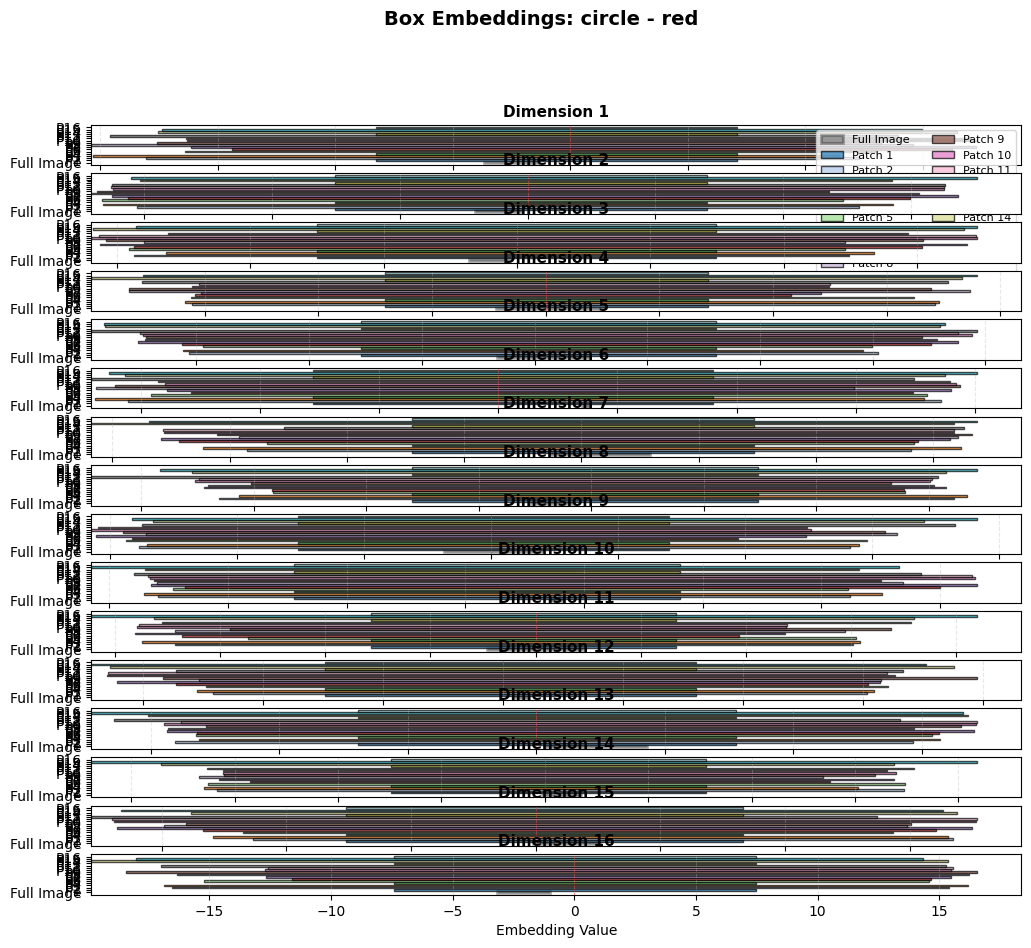

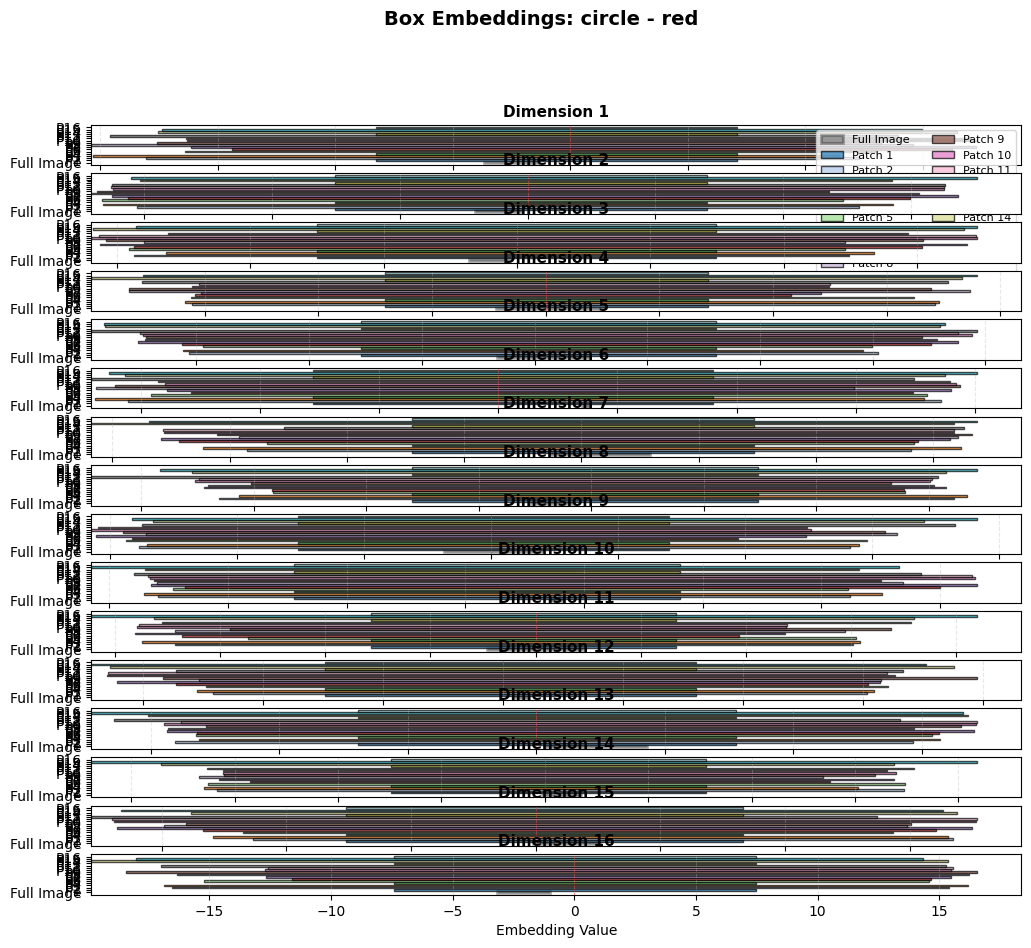

In [ ]:
# Visualize first datapoint (detailed view showing each dimension)
visualize_box_embeddings(embedding_results, sample_idx=0, figsize=(12, 10))

/home/ubuntu/miniconda3/envs/vh-crl/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


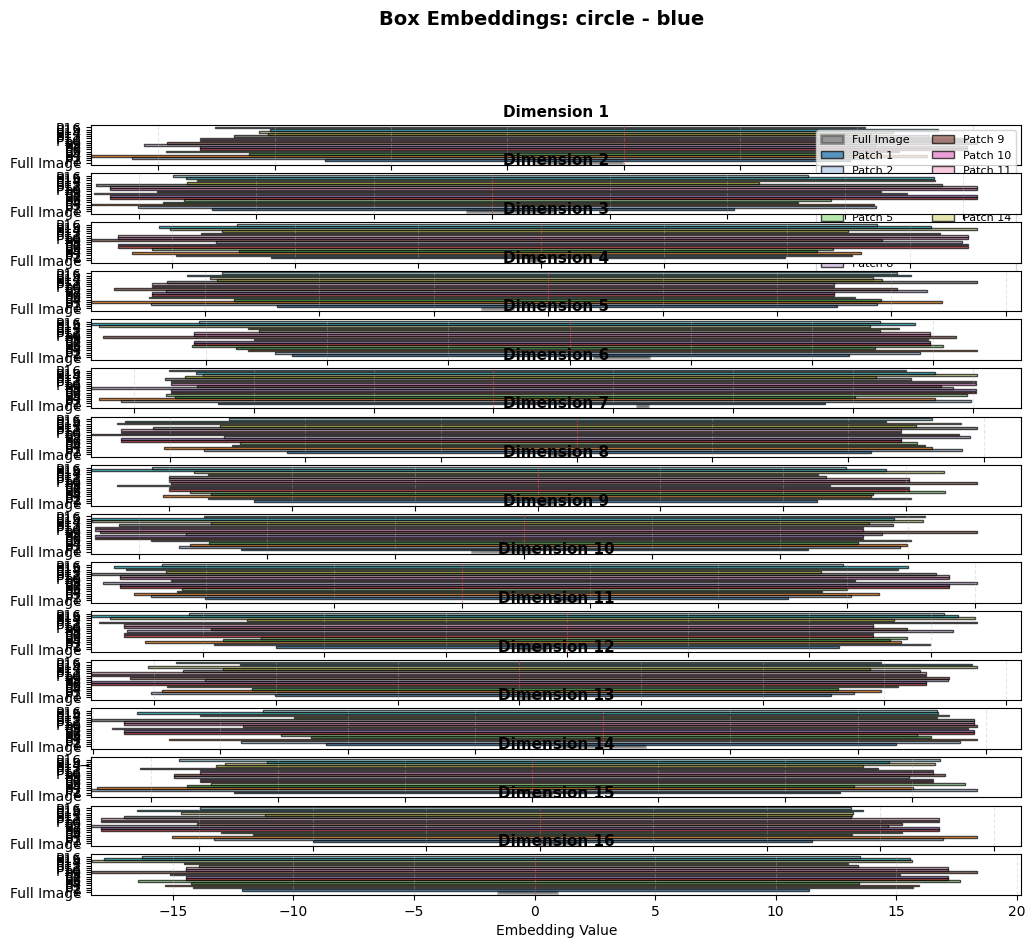

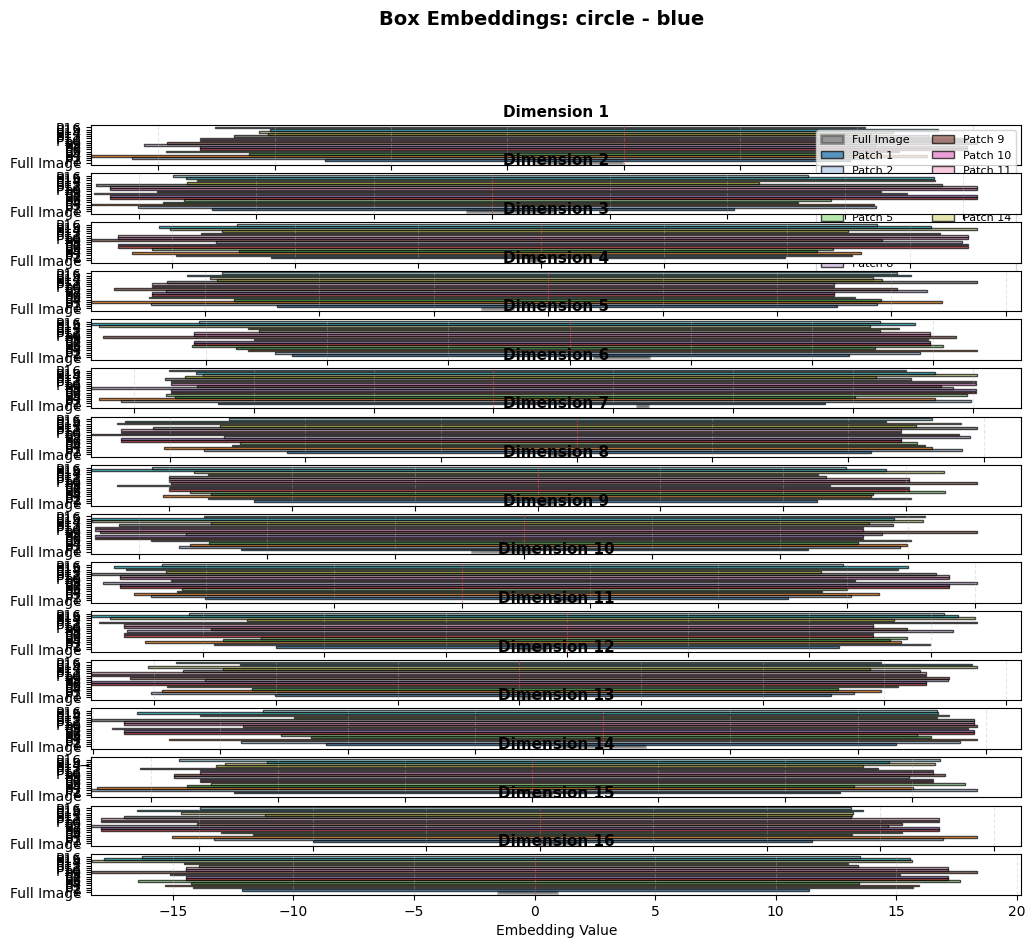

In [23]:
visualize_box_embeddings(embedding_results, sample_idx=1, figsize=(12, 10))

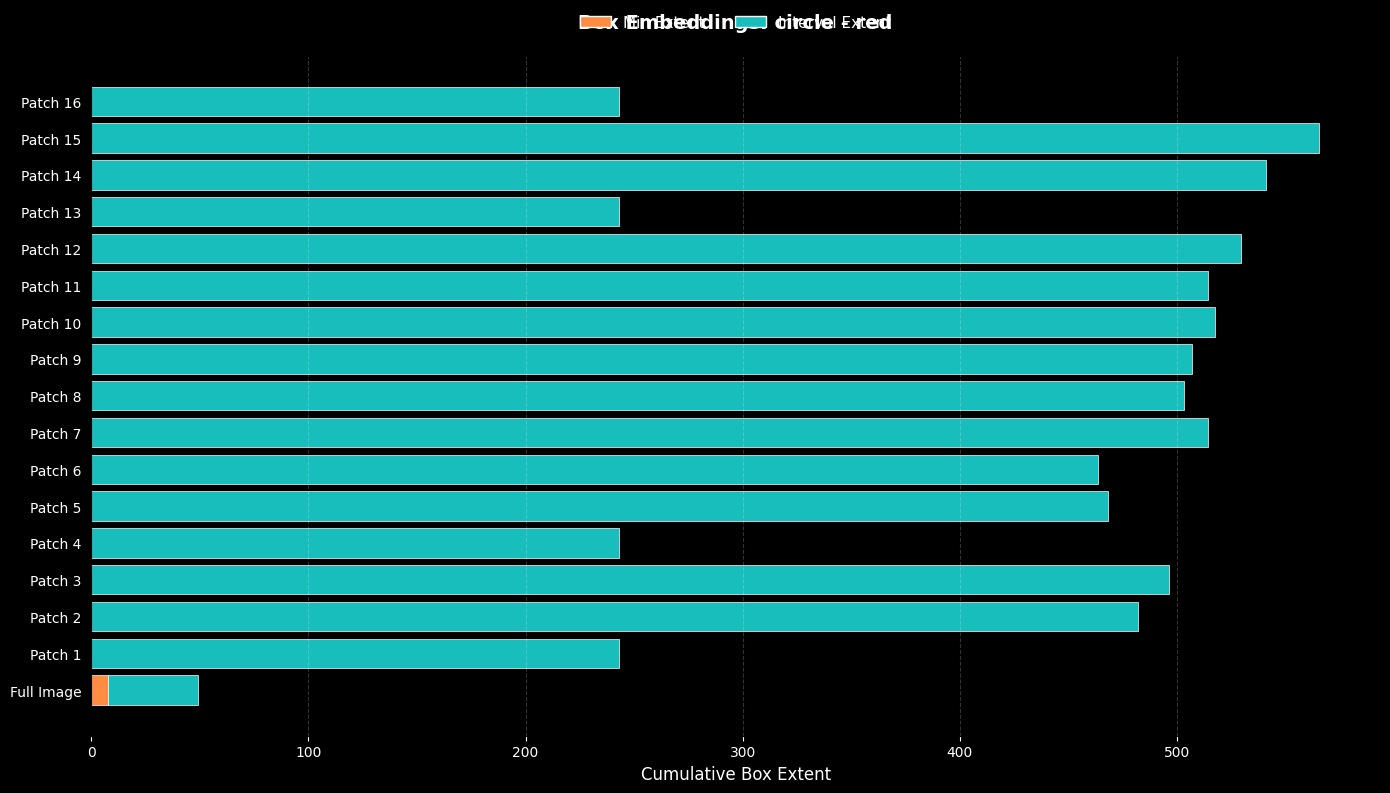

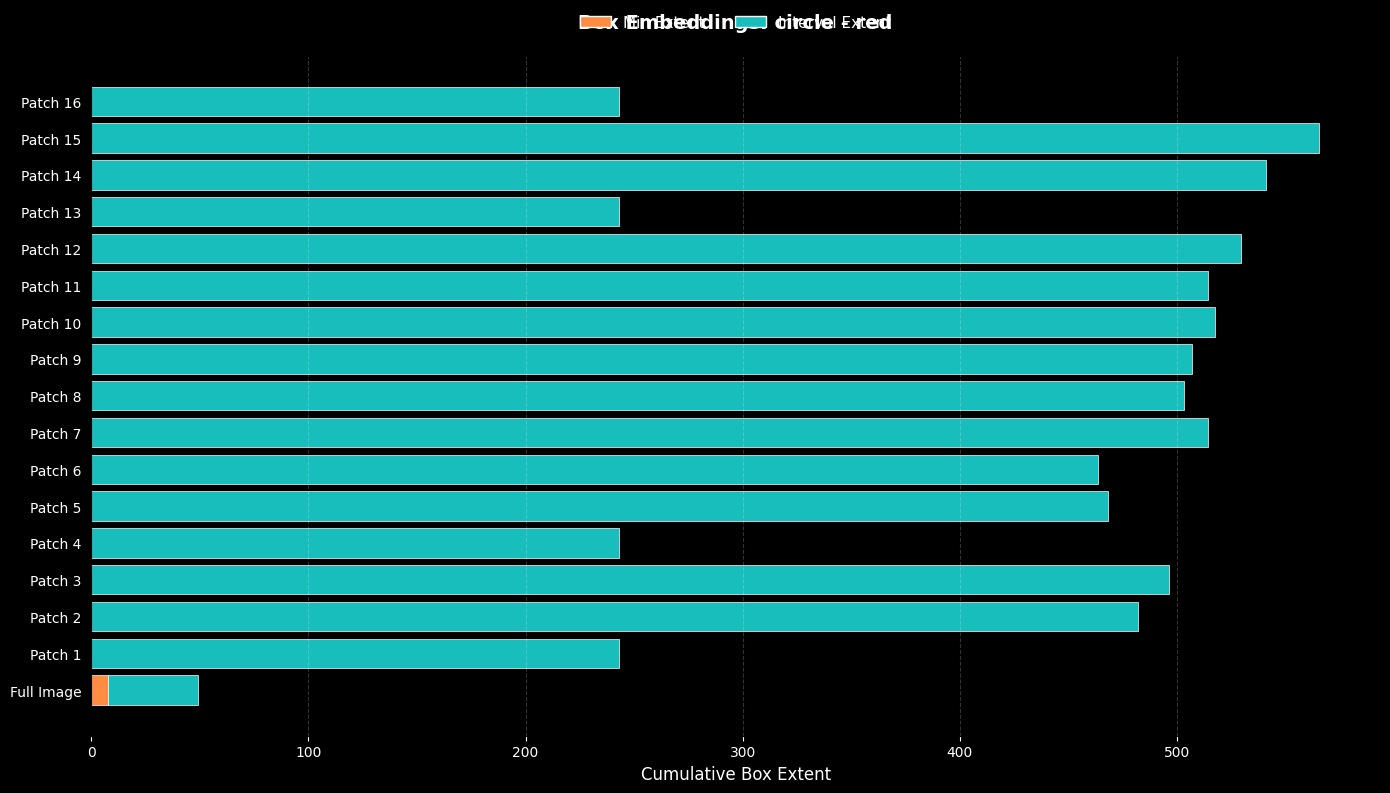

In [24]:
# Visualize in compact style (similar to attached image)
visualize_box_embeddings_compact(embedding_results, sample_idx=0, figsize=(14, 8))

In [25]:
def visualize_dimension_intervals(embedding_results, sample_idx=0, figsize=(14, 10)):
    """
    Visualize box embeddings showing each dimension as a row with interval ranges.
    This matches the style of the attached image more closely.
    
    For each dimension, shows the [min, max] interval for image and all patches.
    """
    result = embedding_results[sample_idx]
    patch_boxes = result["patch_boxes"]  # (num_patches, 2, embed_dim)
    image_box = result["image_box"]  # (2, embed_dim)
    metadata = result["metadata"]
    
    num_patches = patch_boxes.shape[0]
    embed_dim = patch_boxes.shape[2]
    
    fig, ax = plt.subplots(1, 1, figsize=figsize, facecolor='#1a1a1a')
    ax.set_facecolor('#1a1a1a')
    
    # We'll show each dimension as a row
    # For each dimension, we stack bars showing the contribution of each embedding
    y_positions = np.arange(embed_dim)
    
    # Colors - one for each embedding (patches + image)
    colors = plt.cm.tab20(np.linspace(0, 1, num_patches + 1))
    
    # For each dimension, calculate the total span and individual contributions
    for dim_idx in range(embed_dim):
        # Get all mins and maxs for this dimension
        image_min = image_box[0, dim_idx].item()
        image_max = image_box[1, dim_idx].item()
        patch_mins = patch_boxes[:, 0, dim_idx].numpy()
        patch_maxs = patch_boxes[:, 1, dim_idx].numpy()
        
        # Find global min and max for this dimension
        global_min = min(image_min, patch_mins.min())
        global_max = max(image_max, patch_maxs.max())
        
        # Plot image interval
        image_interval = image_max - image_min
        ax.barh(dim_idx, image_interval, left=image_min, height=0.4, 
                color=colors[-1], alpha=0.8, edgecolor='white', linewidth=1,
                label='Full Image' if dim_idx == 0 else None)
        
        # Plot patch intervals (slightly offset vertically for visibility)
        for patch_idx in range(num_patches):
            patch_interval = patch_maxs[patch_idx] - patch_mins[patch_idx]
            offset = 0.35 + (patch_idx * 0.05)  # Small offset for each patch
            ax.barh(dim_idx + offset, patch_interval, left=patch_mins[patch_idx], 
                   height=0.03, color=colors[patch_idx], alpha=0.9, 
                   edgecolor='white', linewidth=0.5,
                   label=f'Patch {patch_idx+1}' if dim_idx == 0 else None)
    
    # Formatting
    ax.set_yticks(y_positions)
    ax.set_yticklabels([f'Dim {i+1}' for i in range(embed_dim)],
                       color='white', fontsize=9)
    ax.set_xlabel('Embedding Value', fontsize=12, color='white', fontweight='bold')
    ax.set_ylabel('Dimension', fontsize=12, color='white', fontweight='bold')
    ax.tick_params(axis='x', colors='white')
    ax.grid(axis='x', alpha=0.2, linestyle='--', color='white')
    ax.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    
    # Legend
    ax.legend(loc='upper right', frameon=True, facecolor='#2a2a2a', 
             edgecolor='white', fontsize=9, labelcolor='white', ncol=2)
    
    # Title
    title = f"Box Embedding Intervals per Dimension\\n{metadata.get('shape', 'N/A').title()} - {metadata.get('color', 'N/A').title()}"
    ax.set_title(title, fontsize=14, fontweight='bold', color='white', pad=15)
    
    plt.tight_layout()
    plt.show()
    
    return fig


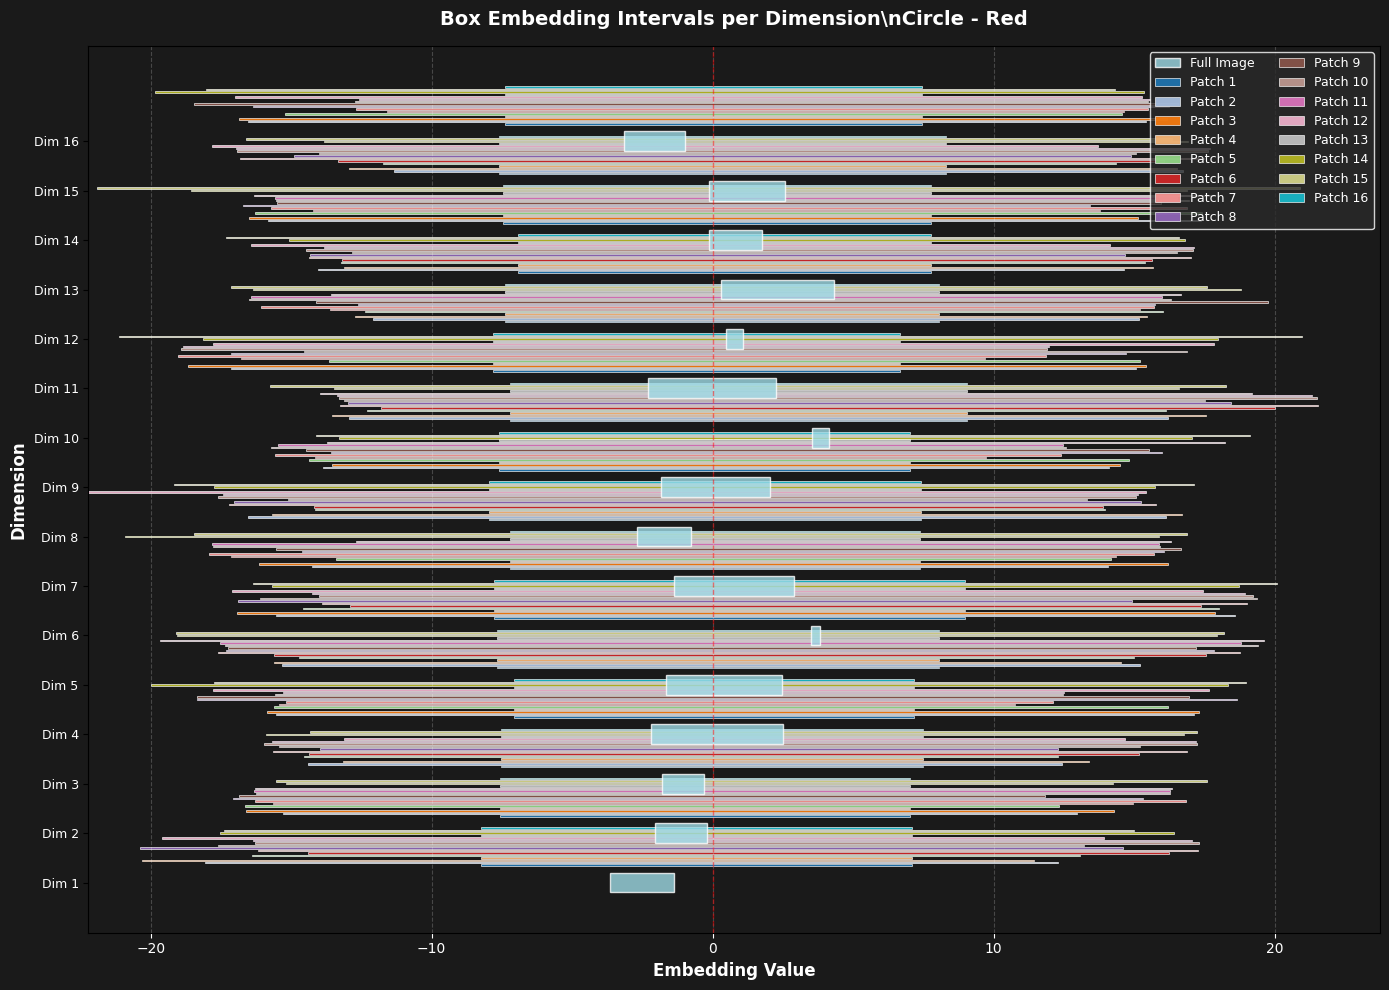

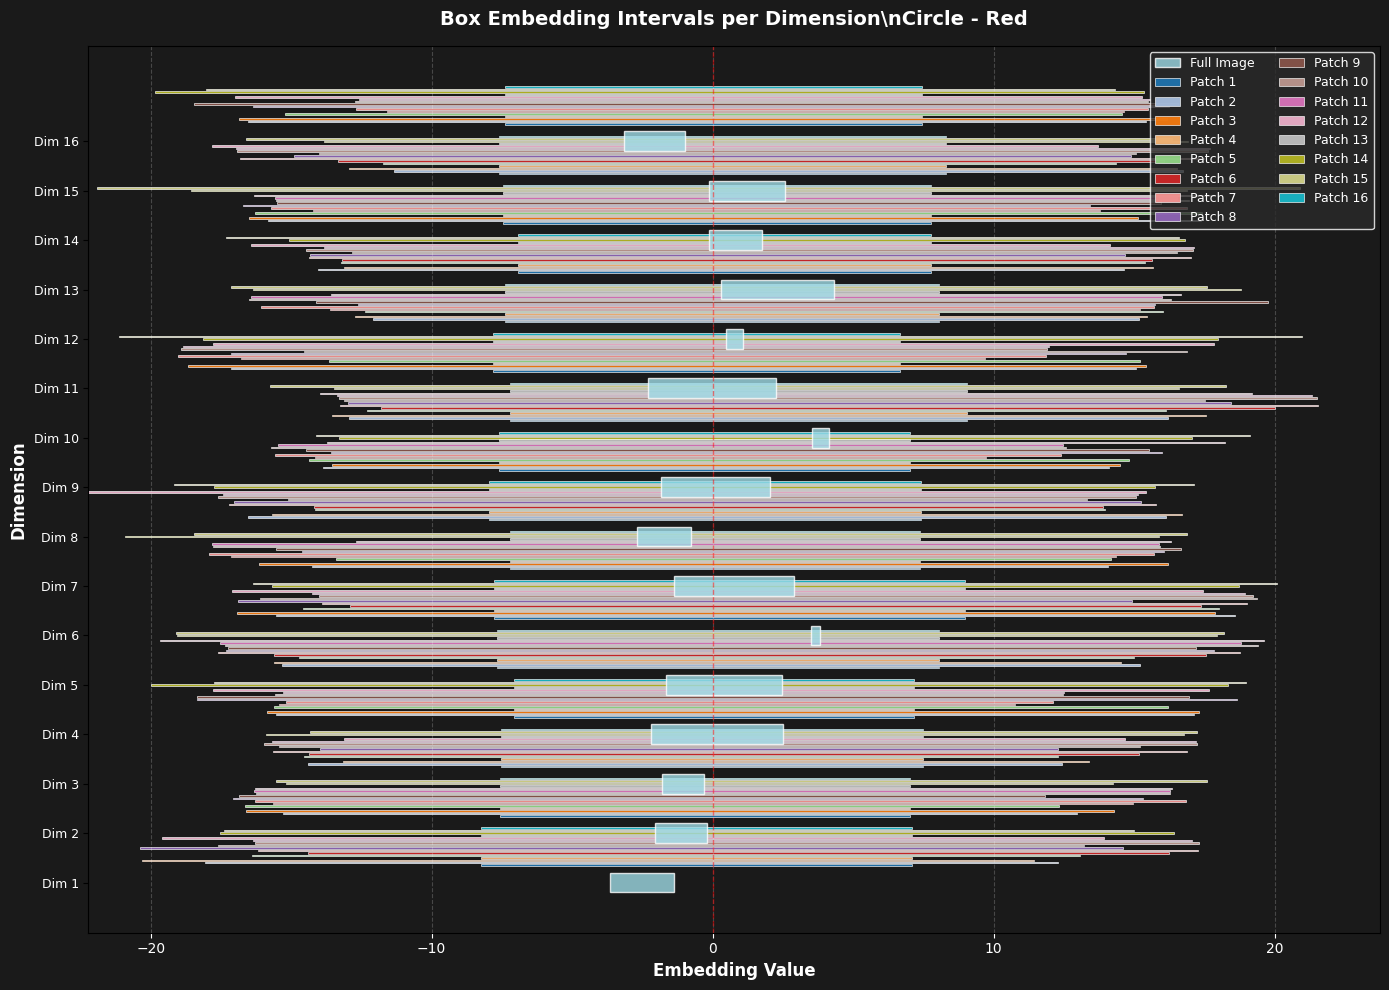

In [26]:
# Visualize with dimension intervals
visualize_dimension_intervals(embedding_results, sample_idx=0, figsize=(14, 10))


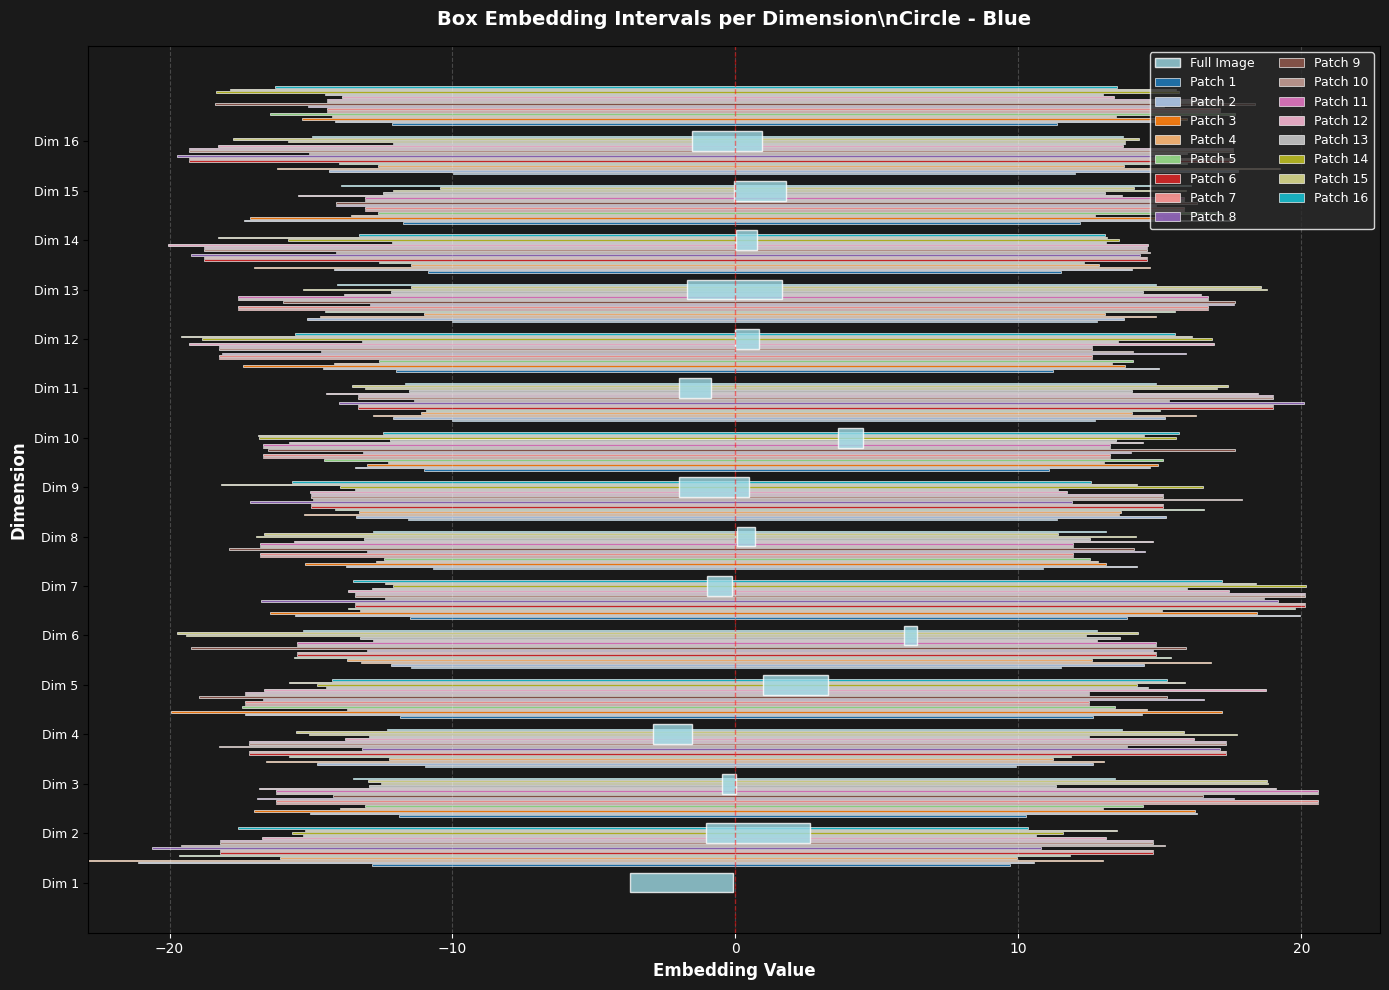

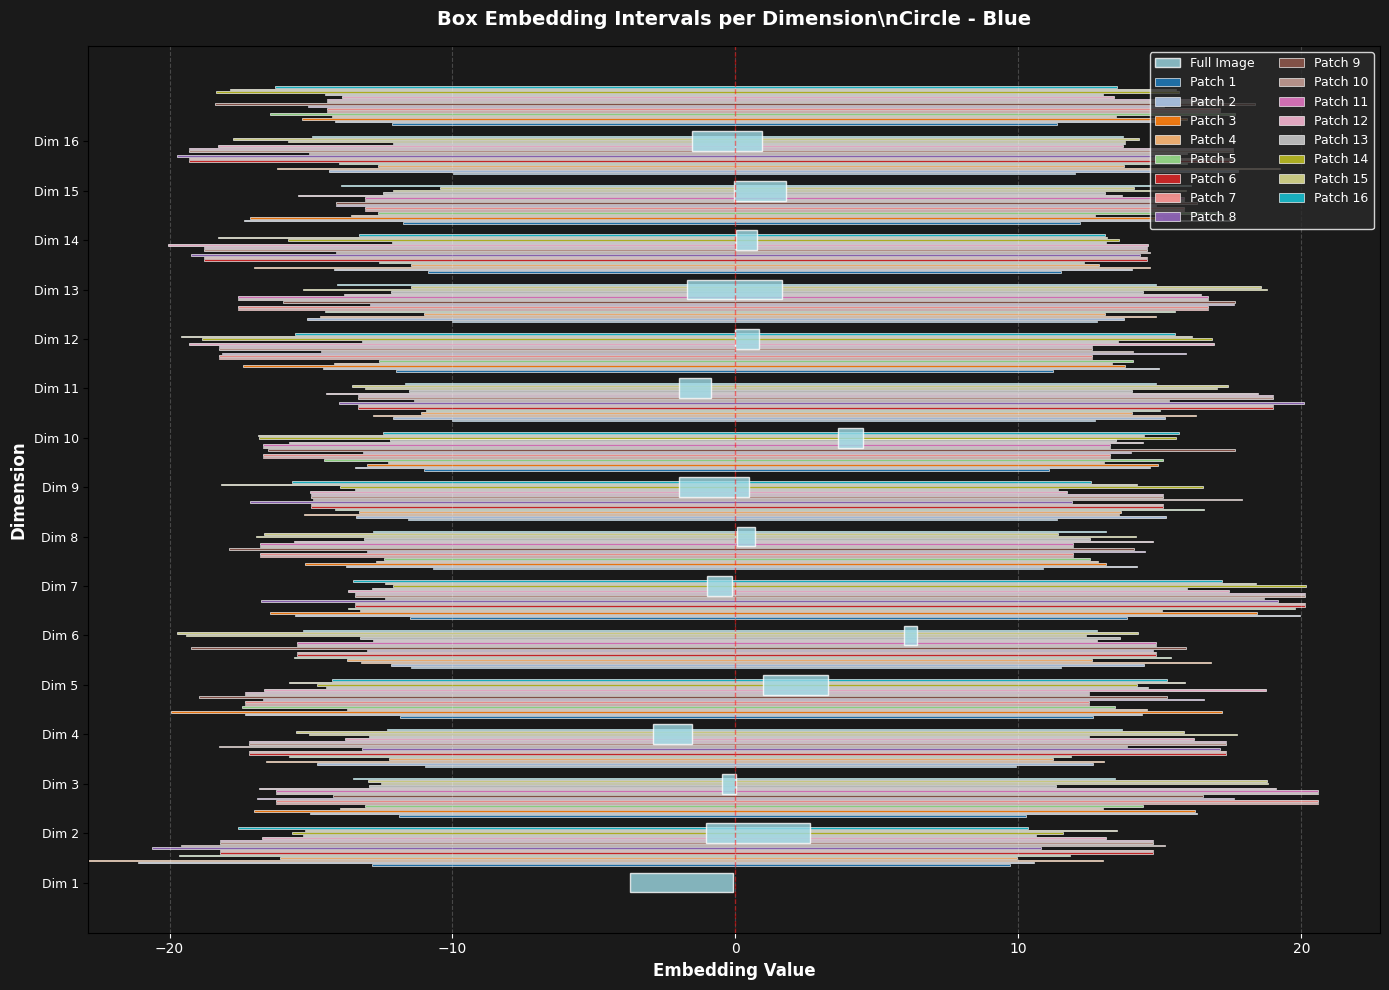

In [27]:
visualize_dimension_intervals(embedding_results, sample_idx=1, figsize=(14, 10))

In [ ]:
# Visualize all samples
for idx in range(len(embedding_results)):
    print(f"\\n{'='*60}")
    print(f"Sample {idx + 1}: {embedding_results[idx]['metadata']}")
    print(f"{'='*60}")
    visualize_dimension_intervals(embedding_results, sample_idx=idx, figsize=(14, 10))


In [ ]:
# Visualize the generated images
fig, axes = plt.subplots(1, len(custom_datapoints), figsize=(15, 4))
if len(custom_datapoints) == 1:
    axes = [axes]

for idx, datapoint in enumerate(custom_datapoints):
    image = datapoint['images'].permute(1, 2, 0).numpy()
    axes[idx].imshow(image)
    axes[idx].set_title(f"{datapoint['metadata']['shape']}\\n{datapoint['metadata']['color']}", 
                       fontsize=10)
    axes[idx].axis('off')

plt.suptitle('Generated Custom Datapoints', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
